<a href="https://colab.research.google.com/github/gowthamsaib/solved-problems/blob/main/Copy_of_fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question: Linear Regression Health Costs Calculator

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the train_dataset and 20% of the data as the test_dataset.

pop off the "expenses" column from these datasets to create new datasets called train_labels and test_labels. Use these labels when training your model.

Create a model and train it with the train_dataset. Run the final cell in this notebook to check your model. The final cell will use the unseen test_dataset to check how well the model generalizes.

To pass the challenge, model.evaluate must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the test_dataset and graph the results.



In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-07-05 21:34:35--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-07-05 21:34:35 (4.83 MB/s) - ‘insurance.csv.4’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# -------------------------
# 3) PREPROCESS & SPLIT
# -------------------------
# One-hot encode categoricals
dataset = pd.get_dummies(dataset, drop_first=True)

# 80/20 train/test
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(
    dataset, test_size=0.2, random_state=42
)

# Separate out the labels
train_labels = train_dataset.pop('expenses')
test_labels  = test_dataset .pop('expenses')

In [4]:
# -------------------------
# 4) NORMALIZATION LAYER
# -------------------------
# Specify input_shape so downstream layers build immediately
normalizer = layers.Normalization(
    axis=-1,
    input_shape=[train_dataset.shape[1]]
)
normalizer.adapt(np.array(train_dataset))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# -------------------------
# 5) BUILD & COMPILE MODEL 
# -------------------------
from tensorflow.keras.losses import Huber

def build_and_compile_model():
    m = keras.Sequential([
        normalizer,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=Huber(),                # more robust to outliers
        metrics=['mae', 'mse']
    )
    return m

model = build_and_compile_model()
# Force-build so summary shows all params
model.build(input_shape=(None, train_dataset.shape[1]))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,538 (45.07 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 17 (72.00 B)

In [6]:
# -------------------------
# 6) TRAIN (EXTENDED)
# -------------------------
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    epochs=125,             # allow more training
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 13360.8467 - mae: 13361.3467 - mse: 316501344.0000 - val_loss: 12649.4463 - val_mae: 12649.9463 - val_mse: 310233152.0000
Epoch 2/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 13198.2979 - mae: 13198.7979 - mse: 316824128.0000 - val_loss: 12621.9473 - val_mae: 12622.4473 - val_mse: 309543104.0000
Epoch 3/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 13404.7236 - mae: 13405.2236 - mse: 320521248.0000 - val_loss: 12522.8682 - val_mae: 12523.3682 - val_mse: 307041120.0000
Epoch 4/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 14268.4277 - mae: 14268.9277 - mse: 368105632.0000 - val_loss: 12248.4111 - val_mae: 12248.9111 - val_mse: 300246624.0000
Epoch 5/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12317.6270 - mae: 12318.1270 - mse: 284311360.0000 - val_loss: 11625.3994 - val_mae: 11625.8994 - val_mse: 285410112.0000
Epoch 6/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 12969.9414 - mae: 12970.4414 -

9/9 - 0s - 10ms/step - loss: 2127.8130 - mae: 2128.3120 - mse: 22643586.0000
Testing set Mean Abs Error: 2128.31 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


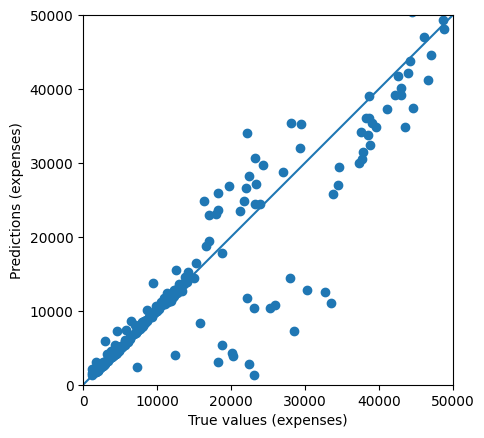

In [7]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
